# **Phishing Website Detection** 

**Objective:**

The objective of this project is to build a model to predict whether a website is phishing or legitimate.

In [ ]:
# Caution: First install the catboost package.
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# Importing the dependencies.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

### **1. Data Collection**

Data is collected from the UCI Repository - https://archive.ics.uci.edu/ml/datasets/Phishing+Websites

In [ ]:
# Loading the data into the pandas dataframe.

data = pd.read_csv('Training Dataset.csv')
data.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


## **2. Data Understanding**

In [ ]:
# Checking the number of rows and columns in the dataset.
data.shape

(11055, 31)

In [ ]:
# Getting some info about the data.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

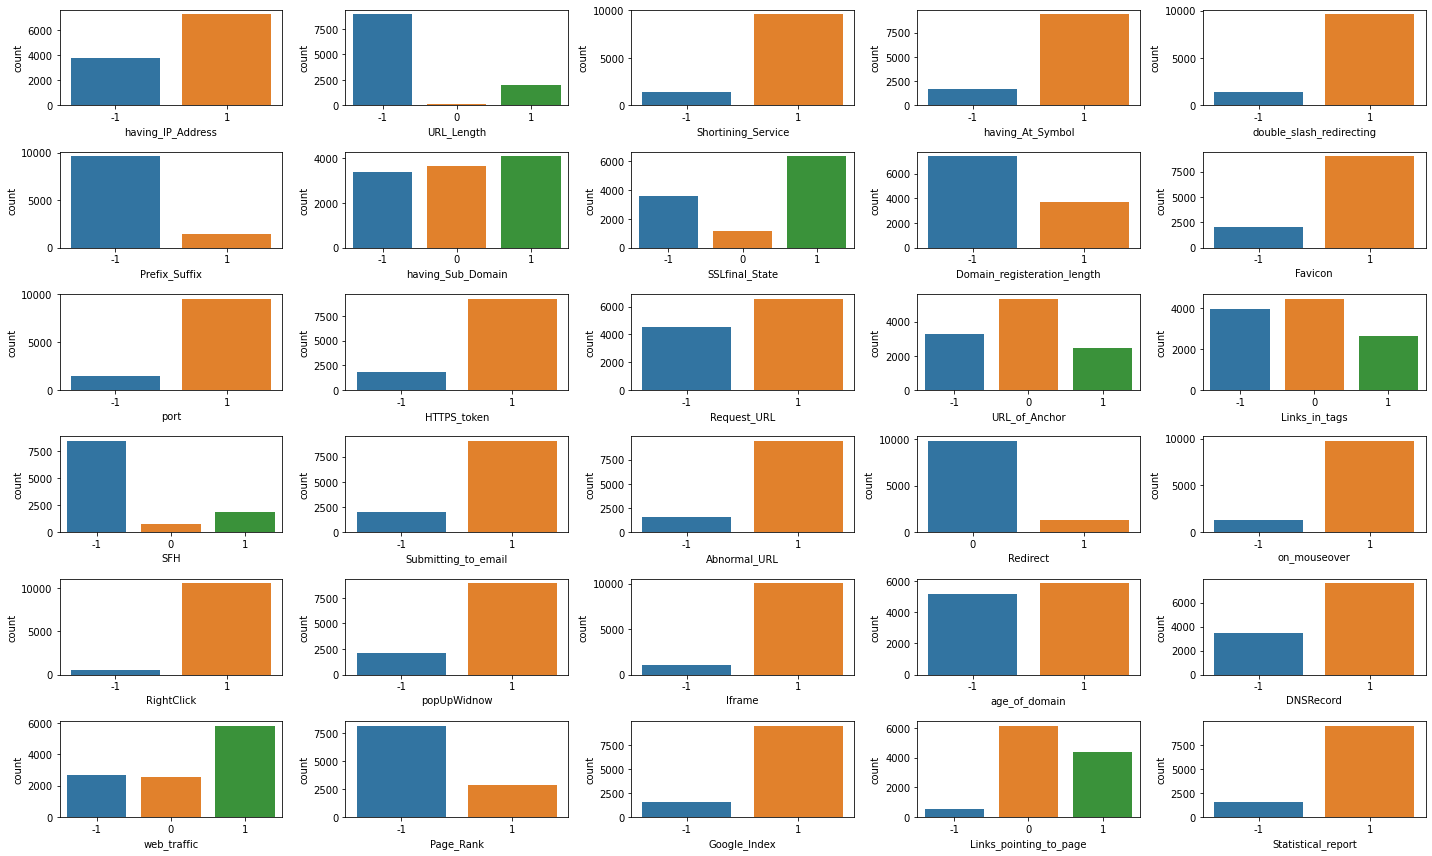

In [ ]:
# Plotting the distribution of all predictors.

plt.figure(figsize=(20,12))
for i in range(30):
  plt.subplot(6,5,i+1)
  sns.countplot(x=data.columns[i], data=data);
plt.tight_layout()  
plt.show()

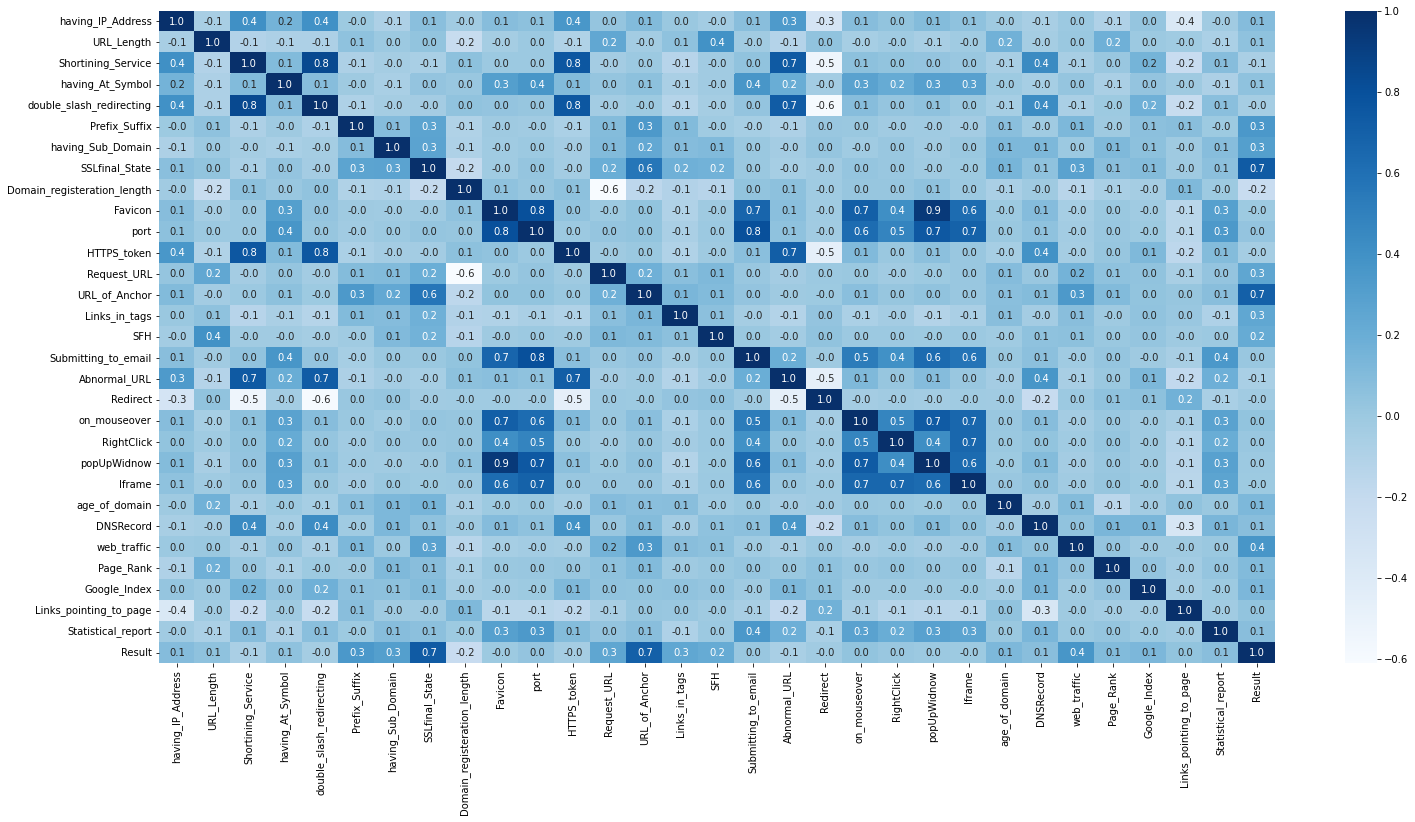

In [ ]:
# constructing the heatmap to visualize the correlation matrix.

correlation = data.corr(method ='spearman')
plt.figure(figsize=(25,12))
sns.heatmap(correlation, cbar=True, fmt='.1f', annot=True, cmap='Blues')
plt.savefig('Correlation Heatmap')

## **3. Data Preparation**

In [ ]:
# checking for missing values.
data.isnull().sum()

having_IP_Address              0
URL_Length                     0
Shortining_Service             0
having_At_Symbol               0
double_slash_redirecting       0
Prefix_Suffix                  0
having_Sub_Domain              0
SSLfinal_State                 0
Domain_registeration_length    0
Favicon                        0
port                           0
HTTPS_token                    0
Request_URL                    0
URL_of_Anchor                  0
Links_in_tags                  0
SFH                            0
Submitting_to_email            0
Abnormal_URL                   0
Redirect                       0
on_mouseover                   0
RightClick                     0
popUpWidnow                    0
Iframe                         0
age_of_domain                  0
DNSRecord                      0
web_traffic                    0
Page_Rank                      0
Google_Index                   0
Links_pointing_to_page         0
Statistical_report             0
Result    

In [ ]:
# statistical measures of the data.
data.describe()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Transforming the all categorical variables into numerical variables by using one-hot encoding.**

In [ ]:
### performing One hot encoding 

data_pre = pd.get_dummies(data.iloc[:,0:-1], columns = data.iloc[:,0:-1].columns)
data_pre

,having_IP_Address_-1,having_IP_Address_1,URL_Length_-1,URL_Length_0,URL_Length_1,Shortining_Service_-1,Shortining_Service_1,having_At_Symbol_-1,having_At_Symbol_1,double_slash_redirecting_-1,...,web_traffic_1,Page_Rank_-1,Page_Rank_1,Google_Index_-1,Google_Index_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1,Statistical_report_-1,Statistical_report_1
0,1,0,0,0,1,0,1,0,1,1,...,0,1,0,0,1,0,0,1,1,0
1,0,1,0,0,1,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,1
2,0,1,0,1,0,0,1,0,1,0,...,1,1,0,0,1,0,1,0,1,0
3,0,1,0,1,0,0,1,0,1,0,...,1,1,0,0,1,1,0,0,0,1
4,0,1,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,0,1,1,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,1,0,1
11051,1,0,0,0,1,0,1,1,0,1,...,1,0,1,0,1,1,0,0,0,1
11052,0,1,1,0,0,0,1,0,1,0,...,1,1,0,0,1,0,1,0,0,1
11053,1,0,1,0,0,0,1,0,1,0,...,1,1,0,0,1,0,0,1,0,1


**Feature Selection:**
Removing the low variance features by using Variance Threshold function.

In [ ]:
# Remove low variance features
selection = VarianceThreshold(threshold=(0.10))    
selection_var= selection.fit_transform(data_pre)
#X.get_feature_names_out(data.co)
data_preproc = data_pre[data_pre.columns[selection.get_support(indices=True)]]
data_preproc.shape

(11055, 60)

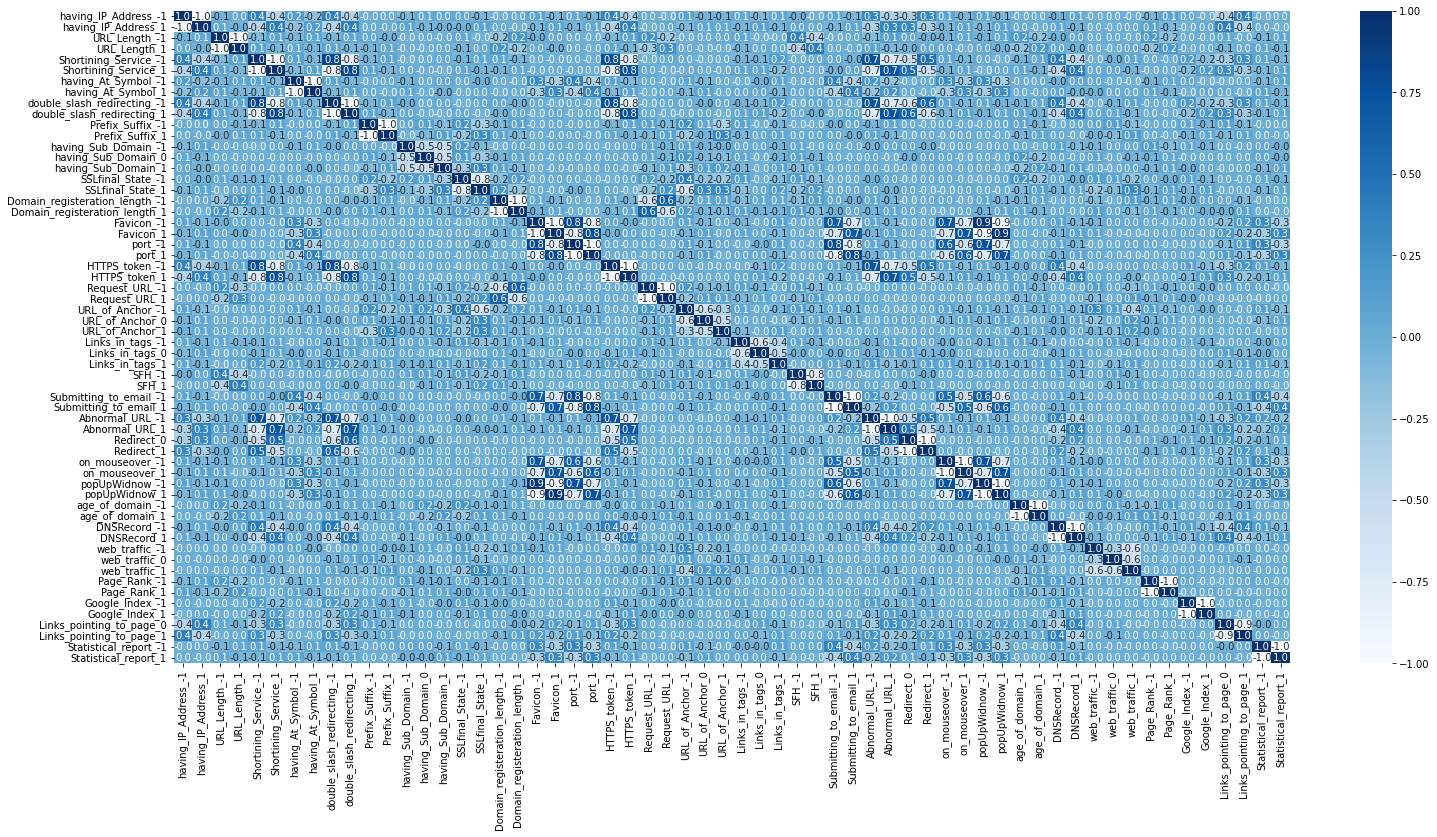

In [ ]:
correlation = data_preproc.corr(method ='spearman')
plt.figure(figsize=(25,12))
sns.heatmap(correlation, cbar=True, fmt='.1f', annot=True, cmap='Blues')
plt.savefig('Correlation Heatmap')

**Feature Selection:**
Removing the highly correlated features by using threshold value = 0.9

In [ ]:
# Dropping variables having high correlation
correlation = data_preproc.corr(method ='spearman')
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(np.bool))

# Dropping features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

data_preproc.drop(to_drop, axis=1, inplace=True)

In [ ]:
# Getting some info after performing data preprocessing.
data_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   having_IP_Address_-1            11055 non-null  uint8
 1   having_IP_Address_1             11055 non-null  uint8
 2   URL_Length_-1                   11055 non-null  uint8
 3   URL_Length_1                    11055 non-null  uint8
 4   Shortining_Service_-1           11055 non-null  uint8
 5   Shortining_Service_1            11055 non-null  uint8
 6   having_At_Symbol_-1             11055 non-null  uint8
 7   having_At_Symbol_1              11055 non-null  uint8
 8   double_slash_redirecting_-1     11055 non-null  uint8
 9   double_slash_redirecting_1      11055 non-null  uint8
 10  Prefix_Suffix_-1                11055 non-null  uint8
 11  Prefix_Suffix_1                 11055 non-null  uint8
 12  having_Sub_Domain_-1            11055 non-null  uint8
 13  h

 1    6157
-1    4898
Name: Result, dtype: int64


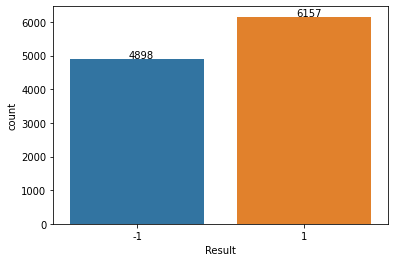

In [ ]:
# checking the distribution of Target Varibale.
print(data['Result'].value_counts())

ax = sns.countplot(data['Result'])
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), 
                    (p.get_x()+.35, p.get_height()+20))    

**-1 -> phishing**

**1 -> legitimate**

In [ ]:
data.groupby('Result').mean()                    

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
Result,,,,,,,,,,,,,,,,,,,,,
-1,0.213557,-0.682523,0.790118,0.658228,0.770519,-1.000000,-0.209473,-0.479788,-0.098408,0.628828,...,0.908126,0.613312,0.81911,-0.074724,0.298489,-0.033891,-0.586362,0.621478,0.323193,0.657411
1,0.393536,-0.593958,0.697905,0.734286,0.718369,-0.524119,0.281468,0.832223,-0.526393,0.628390,...,0.918467,0.613448,0.81517,0.169401,0.439662,0.542797,-0.401981,0.801202,0.360565,0.769043


**Summary from Data Preparation:**

1. No missing values.
2. There is no outlier.
3. All predictor variables are categorical, converted into numerical variables by using one-hot encoding.
4. There are 8 variables having lower variance than 0.1, are removed. 
5. There are 2 highly correlated variables when considering the cutoff value as 0.90. That are also removed.
6. Slightly imbalance in the dataset (legitimate(1) cases are more than phishing(-1) cases)




## **4. Splitting the Data**

In [ ]:
# Sepratating the data into X and y.

X = data_preproc.copy()
y = data['Result']

X.shape, y.shape     

((11055, 58), (11055,))

In [ ]:
# Splitting the data into train and test sets: 70-30 split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state = 12,
                                                    shuffle=True, stratify=y)
X.shape, X_train.shape, X_test.shape, data.shape

((11055, 58), (7738, 58), (3317, 58), (11055, 31))

##**5. Model Building**

### **5.1. Logistic Regression**

In [ ]:
# Logistic Regression

# Building pipelines
pipe_lr = Pipeline([('scaler', StandardScaler()),
			('clf', LogisticRegression())])

# Grid Search parameters
scale = [StandardScaler(), MinMaxScaler(), 'passthrough']   # used in all models

grid_param_lr = {'scaler': scale,
                 #'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']
                 }

# Performing Grid Searches        
gs_lr = RandomizedSearchCV(estimator=pipe_lr,
                      param_distributions=grid_param_lr,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)

gs_lr.fit(X_train, y_train)

print('Best parameter: ', gs_lr.best_params_)
print('Average Validation score: ', 
      round(gs_lr.cv_results_['mean_test_score'].mean(),4))

Best parameter:  {'scaler': MinMaxScaler()}
Average Validation score:  0.9462


### **5.2. Decision Tree**

In [ ]:
# Decision Tree Classifier

# Building pipelines
pipe_dt = Pipeline([('scaler', StandardScaler()),
			('clf', DecisionTreeClassifier(random_state=5))])

# Grid Search parameters
grid_param_dt = {'scaler': scale,
                 'clf__max_depth': range(2,25,2),
                 'clf__criterion': ['gini', 'entropy']}

# Performing Grid Searches        
gs_dt = RandomizedSearchCV(estimator=pipe_dt,
                      param_distributions=grid_param_dt,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)

gs_dt.fit(X_train, y_train)

print('Best parameter: ', gs_dt.best_params_)
print('Average Validation score: ', 
      round(gs_dt.cv_results_['mean_test_score'].mean(),4))

Best parameter:  {'scaler': StandardScaler(), 'clf__max_depth': 16, 'clf__criterion': 'entropy'}
Average Validation score:  0.9459


### **5.3. Support Vector Machines (SVM)**

In [ ]:
# SVM

# Building pipelines
pipe_svm = Pipeline([('scaler', StandardScaler()),
			('clf', svm.SVC(random_state=5))])

# Grid Search parameters
grid_param_svm = [{'scaler': scale,
                  'clf__kernel': ['poly', 'rbf'],
                  'clf__degree': [5,6,7,8,9],
                  'clf__C': [1,3,5,7,9,11,13]}]

# Performing Grid Searches 
gs_svm = RandomizedSearchCV(estimator=pipe_svm,
                      param_distributions=grid_param_svm,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)   

gs_svm.fit(X_train, y_train)

print('Best parameter: ', gs_svm.best_params_)
print('Average Validation score: ', 
      round(gs_svm.cv_results_['mean_test_score'].mean(),4))

Best parameter:  {'scaler': 'passthrough', 'clf__kernel': 'poly', 'clf__degree': 7, 'clf__C': 7}
Average Validation score:  0.9638


### **5.4. k Nearest Neighbors (kNN)**

In [ ]:
# K Neighbors Classifier

# Building pipelines
pipe_knn = Pipeline([('scaler', StandardScaler()),
			('clf', KNeighborsClassifier())])

# Grid Search parameters
grid_param_knn = {'scaler': scale,
                  'clf__n_neighbors': range(1,20)}

# Performing Grid Searches     
gs_knn = RandomizedSearchCV(estimator=pipe_knn,
                      param_distributions=grid_param_knn,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)    

gs_knn.fit(X_train, y_train)

print('Best parameter: ', gs_knn.best_params_)
print('Average Validation score: ', 
      round(gs_knn.cv_results_['mean_test_score'].mean(),4))

Best parameter:  {'scaler': 'passthrough', 'clf__n_neighbors': 1}
Average Validation score:  0.9491


### **5.5. Multilayer Perceptrons (MLP)**

In [ ]:
# Multilayer Perceptrons model

# Building pipelines
pipe_mlp = Pipeline([('scaler', StandardScaler()), 
                     ('clf', MLPClassifier())])

# Grid Search parameters
grid_param_mlp = {'scaler': scale,
                 'clf__alpha': [0.0001,0.001,0.1],
                 'clf__hidden_layer_sizes': [[50], [100], [50,100]]}  

# Performing Grid Searches
gs_mlp = RandomizedSearchCV(estimator=pipe_mlp,
                      param_distributions=grid_param_mlp,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)  

gs_mlp.fit(X_train, y_train)

print('Best parameter: ', gs_mlp.best_params_)
print('Average Validation score: ', 
      round(gs_mlp.cv_results_['mean_test_score'].mean(),4))

Best parameter:  {'scaler': StandardScaler(), 'clf__hidden_layer_sizes': [100], 'clf__alpha': 0.1}
Average Validation score:  0.9669


### **5.6. Random Forest**

In [ ]:
# Random Forest Classifier

# Building pipelines
pipe_rf = Pipeline([('scaler', StandardScaler()),
			('clf', RandomForestClassifier(random_state=5))])

# Grid Search parameters
grid_param_rf = {'scaler': scale,
                 'clf__n_estimators': [10,20,25,30,50],
                 'clf__max_depth': [2,4,8,16,32,64]}  

# Performing Grid Searches
gs_rf = RandomizedSearchCV(estimator=pipe_rf,
                      param_distributions=grid_param_rf,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)  

gs_rf.fit(X_train, y_train)

print('Best parameter: ', gs_rf.best_params_)
print('Average Validation score: ', 
      round(gs_rf.cv_results_['mean_test_score'].mean(),4))

Best parameter:  {'scaler': MinMaxScaler(), 'clf__n_estimators': 30, 'clf__max_depth': 32}
Average Validation score:  0.9536


### **5.7. XGBoost**

In [ ]:
# XGBoost Classification Model

# Building pipelines
pipe_xgb = Pipeline([('scaler', StandardScaler()),
			('clf', XGBClassifier())])

# Grid Search parameters
grid_param_xgb = {'scaler': scale,
                 'clf__learning_rate': [0.01,0.02,0.03,0.04,0.05],
                 'clf__n_estimators': [5,10,20,25,40,70,100],
                 'clf__max_depth': [8,16,32,64,128]}

# Performing Grid Searches        
gs_xgb = RandomizedSearchCV(estimator=pipe_xgb,
                      param_distributions=grid_param_xgb,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)

gs_xgb.fit(X_train, y_train)

print('Best parameter: ', gs_xgb.best_params_)
print('Average Validation score: ', 
      round(gs_xgb.cv_results_['mean_test_score'].mean(),4))

Best parameter:  {'scaler': StandardScaler(), 'clf__n_estimators': 100, 'clf__max_depth': 16, 'clf__learning_rate': 0.04}
Average Validation score:  0.954


### **5.8. CatBoost**

In [ ]:
# CatBoost Classification Model

# Building pipelines
pipe_ctb = Pipeline([('scaler', StandardScaler()),
			('clf', CatBoostClassifier(task_type="GPU"))])

# Grid Search parameters
#scorer = make_scorer(accuracy_score)
grid_param_ctb = {'scaler': scale,
                  #'clf__learning_rate': [0.01,0.02,0.03,0.04,0.05],
                  #'clf__iterations': [250,500,600,700,900,1000],
                  #'clf__depth': [10,20,40],
                  #'clf__loss_function': ['Logloss', 'CrossEntropy'],
                  #'clf__l2_leaf_reg': np.logspace(-20, -19, 3)
                  }

# Performing Grid Searches        
gs_ctb = RandomizedSearchCV(estimator=pipe_ctb,
                      param_distributions=grid_param_ctb,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)

gs_ctb.fit(X_train, y_train)

print('Best parameter: ', gs_ctb.best_params_)
print('Average Validation score: ', 
      round(gs_ctb.cv_results_['mean_test_score'].mean(),4))

Learning rate set to 0.030123
0:	learn: 0.6333134	total: 70.2ms	remaining: 1m 10s
1:	learn: 0.5823831	total: 115ms	remaining: 57.6s
2:	learn: 0.5372741	total: 157ms	remaining: 52s
3:	learn: 0.4963847	total: 186ms	remaining: 46.4s
4:	learn: 0.4612078	total: 222ms	remaining: 44.2s
5:	learn: 0.4302680	total: 263ms	remaining: 43.6s
6:	learn: 0.4017764	total: 299ms	remaining: 42.4s
7:	learn: 0.3789539	total: 335ms	remaining: 41.5s
8:	learn: 0.3599837	total: 399ms	remaining: 43.9s
9:	learn: 0.3411342	total: 435ms	remaining: 43.1s
10:	learn: 0.3237109	total: 471ms	remaining: 42.4s
11:	learn: 0.3087000	total: 507ms	remaining: 41.8s
12:	learn: 0.2967224	total: 535ms	remaining: 40.6s
13:	learn: 0.2838516	total: 580ms	remaining: 40.8s
14:	learn: 0.2744475	total: 620ms	remaining: 40.7s
15:	learn: 0.2648287	total: 657ms	remaining: 40.4s
16:	learn: 0.2576012	total: 686ms	remaining: 39.7s
17:	learn: 0.2486703	total: 724ms	remaining: 39.5s
18:	learn: 0.2411571	total: 762ms	remaining: 39.3s
19:	learn: 

### **5.9. LightGBM**

In [ ]:
# LightGBM Classification Model

# Building pipelines
pipe_lgm = Pipeline([('scaler', StandardScaler()),
			('clf', LGBMClassifier())])

# Grid Search parameters
grid_param_lgm = {'scaler': scale,
                  'clf__n_estimators': [100,200,300,400,600,800],
                  'clf__max_depth': [10,15,20,25,30]
                  }

# Performing Grid Searches        
gs_lgm = RandomizedSearchCV(estimator=pipe_lgm,
                      param_distributions=grid_param_lgm,
                      scoring='f1',
                      cv=5,
                      n_jobs=-1)

gs_lgm.fit(X_train, y_train)

print('Best parameter: ', gs_lgm.best_params_)
print('Average Validation score: ', 
      round(gs_lgm.cv_results_['mean_test_score'].mean(),4))

Best parameter:  {'scaler': StandardScaler(), 'clf__n_estimators': 800, 'clf__max_depth': 25}
Average Validation score:  0.9698


### **5.10. Stacking Ensemble Learning**

In [ ]:
# get a stacking ensemble of the models
def get_stacking():
  # define the base models
  level0 =[
          #('lr', make_pipeline(MinMaxScaler(), LogisticRegression())),
          #('dt', make_pipeline(MinMaxScaler(), DecisionTreeClassifier(max_depth=24, criterion='entropy'))),
          #('svm', svm.SVC(kernel='poly', degree=7, C= 3)),
          #('knn', KNeighborsClassifier(n_neighbors=1)),
          ('MLP', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes= [100], alpha= 0.0001))),
          #('rf',  make_pipeline(StandardScaler(), RandomForestClassifier())),
          ('xgb', make_pipeline(MinMaxScaler(), XGBClassifier())),
          ('ctb', make_pipeline(MinMaxScaler(), CatBoostClassifier())),
          ('lgb', make_pipeline(StandardScaler(), LGBMClassifier()))
          ]
	# define meta learner model
  level1 = LGBMClassifier(n_estimators= 400, max_depth= 15)
  # define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1,cv=10)
  return model

# get a list of models to evaluate
def get_models():
	models ={
	'LR' : make_pipeline(MinMaxScaler(), LogisticRegression()),
  'DT' : make_pipeline(MinMaxScaler(), DecisionTreeClassifier()),
	'SVM' : svm.SVC(kernel='poly'),
	'KNN' : KNeighborsClassifier(),
	'MLP' : make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes= [100], alpha= 0.0001)),
  'RF' : make_pipeline(StandardScaler(), RandomForestClassifier()),
	'XGB' : make_pipeline(MinMaxScaler(), XGBClassifier()),
  'CATB' : make_pipeline(MinMaxScaler(), CatBoostClassifier()),
	'LGTB' : make_pipeline(StandardScaler(), LGBMClassifier()),
  'Stacking': get_stacking()
  }
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores  

# get the models to evaluate
models = get_models()
# evaluate the models and store results
times, results, names = [], [], []
for name, model in models.items():
  start_time = time.time()
  scores = evaluate_model(model, X_train, y_train)
  end_time = time.time()
  times.append(str(round(end_time - start_time,5)) + ' sec')
  results.append(scores)
  names.append(name)
  print(f'{name} {round(np.mean(scores),4)}  ({round(np.std(scores),4)})  time-{end_time - start_time}')

LR 0.9465  (0.0069)  time-3.619410753250122
DT 0.9636  (0.0078)  time-0.9205296039581299
SVM 0.9649  (0.0051)  time-14.529166460037231
KNN 0.956  (0.0062)  time-4.191049098968506
MLP 0.9729  (0.0059)  time-187.75240230560303
RF 0.9731  (0.0062)  time-13.048763275146484
XGB 0.9542  (0.0064)  time-21.698131561279297
CATB 0.9713  (0.006)  time-179.44212293624878
LGTB 0.9688  (0.006)  time-9.939381837844849
Stacking 0.9688  (0.0059)  time-4152.831295251846


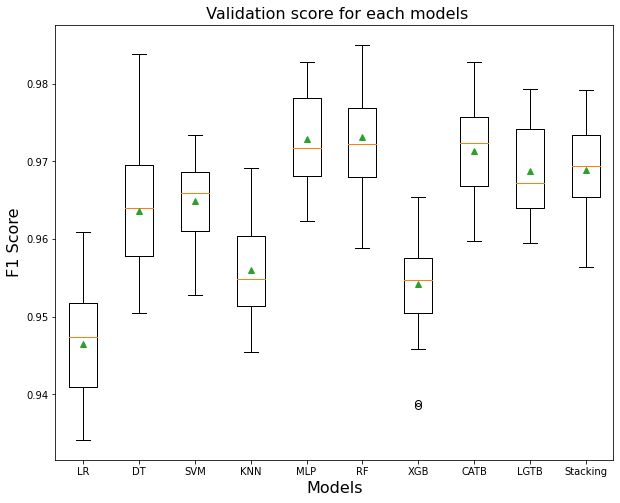

In [ ]:
# plot model performance for comparison
plt.figure(figsize=(10,8))
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Models',fontsize=16); plt.ylabel('F1 Score',fontsize=16)
plt.title(' Validation score for each models',fontsize=16)
plt.show()

In [ ]:
col = ['Model_Type', 'F1 Score', 'Time']
f1_val = [np.mean(i) for i in results]
Validation = pd.DataFrame(zip(names ,f1_val,times), columns=col) 
Validation

,Model_Type,F1 Score,Time
0,LR,0.946532,3.61941 sec
1,DT,0.963649,0.92053 sec
2,SVM,0.964913,14.52917 sec
3,KNN,0.956018,4.19105 sec
4,MLP,0.972907,187.7524 sec
5,RF,0.973078,13.04876 sec
6,XGB,0.954196,21.69813 sec
7,CATB,0.971344,179.44212 sec
8,LGTB,0.968803,9.93938 sec
9,Stacking,0.968820,4152.8313 sec


## 6.Model Evaluation

In [ ]:
# get the models to evaluate
final_model = get_models()

# evaluate the models and store results
report_train, report_test = [], []
for name, model in tqdm(final_model.items(), desc="Loading..."):
    model.fit(X_train, y_train)

    #for training
    y_pred_t = model.predict(X_train)
    acc_t = accuracy_score(y_train, y_pred_t)
    pre_t = precision_score(y_train, y_pred_t)
    rec_t = recall_score(y_train, y_pred_t)
    f1_t  = f1_score(y_train, y_pred_t)
    auc_t = roc_auc_score(y_train, y_pred_t)
    report_train.append([name,acc_t,pre_t,rec_t,f1_t,auc_t])

    # for testing
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    report_test.append([name,acc,pre,rec,f1,auc])

Loading...:  70%|███████   | 7/10 [00:23<00:10,  3.64s/it]

Learning rate set to 0.024682
0:	learn: 0.6520472	total: 3.1ms	remaining: 3.1s
1:	learn: 0.6134062	total: 8.96ms	remaining: 4.47s
2:	learn: 0.5733661	total: 14.4ms	remaining: 4.77s
3:	learn: 0.5425477	total: 19.8ms	remaining: 4.94s
4:	learn: 0.5155548	total: 23.9ms	remaining: 4.75s
5:	learn: 0.4835960	total: 29.1ms	remaining: 4.82s
6:	learn: 0.4572185	total: 34.5ms	remaining: 4.9s
7:	learn: 0.4344861	total: 40.1ms	remaining: 4.97s
8:	learn: 0.4159395	total: 45.5ms	remaining: 5.01s
9:	learn: 0.4002715	total: 51.1ms	remaining: 5.06s
10:	learn: 0.3812019	total: 56.6ms	remaining: 5.08s
11:	learn: 0.3639507	total: 62ms	remaining: 5.1s
12:	learn: 0.3466822	total: 67.1ms	remaining: 5.1s
13:	learn: 0.3310491	total: 72.2ms	remaining: 5.08s
14:	learn: 0.3180530	total: 77.5ms	remaining: 5.09s
15:	learn: 0.3052701	total: 83.2ms	remaining: 5.11s
16:	learn: 0.2936100	total: 88.5ms	remaining: 5.12s
17:	learn: 0.2851564	total: 94ms	remaining: 5.13s
18:	learn: 0.2752746	total: 99.8ms	remaining: 5.15s
1

Loading...:  80%|████████  | 8/10 [00:29<00:08,  4.39s/it]

985:	learn: 0.0455741	total: 5.63s	remaining: 80ms
986:	learn: 0.0455579	total: 5.64s	remaining: 74.3ms
987:	learn: 0.0455306	total: 5.65s	remaining: 68.6ms
988:	learn: 0.0455041	total: 5.66s	remaining: 62.9ms
989:	learn: 0.0454888	total: 5.66s	remaining: 57.2ms
990:	learn: 0.0454734	total: 5.67s	remaining: 51.5ms
991:	learn: 0.0454427	total: 5.67s	remaining: 45.7ms
992:	learn: 0.0454149	total: 5.68s	remaining: 40ms
993:	learn: 0.0453884	total: 5.68s	remaining: 34.3ms
994:	learn: 0.0453578	total: 5.69s	remaining: 28.6ms
995:	learn: 0.0453348	total: 5.69s	remaining: 22.9ms
996:	learn: 0.0453058	total: 5.7s	remaining: 17.2ms
997:	learn: 0.0452812	total: 5.71s	remaining: 11.4ms
998:	learn: 0.0452341	total: 5.71s	remaining: 5.72ms
999:	learn: 0.0451991	total: 5.72s	remaining: 0us


Loading...:  90%|█████████ | 9/10 [00:30<00:03,  3.20s/it]

Streaming output truncated to the last 5000 lines.
4:	learn: 0.5210529	total: 20.8ms	remaining: 4.13s
5:	learn: 0.4943926	total: 25.7ms	remaining: 4.26s
6:	learn: 0.4683542	total: 30.5ms	remaining: 4.32s
7:	learn: 0.4456145	total: 35.4ms	remaining: 4.39s
8:	learn: 0.4270350	total: 40.1ms	remaining: 4.41s
9:	learn: 0.4111100	total: 46.7ms	remaining: 4.63s
10:	learn: 0.3918791	total: 58.5ms	remaining: 5.26s
11:	learn: 0.3743792	total: 65.6ms	remaining: 5.4s
12:	learn: 0.3573899	total: 70.8ms	remaining: 5.37s
13:	learn: 0.3414994	total: 75.8ms	remaining: 5.34s
14:	learn: 0.3280489	total: 81.2ms	remaining: 5.33s
15:	learn: 0.3149080	total: 93.3ms	remaining: 5.74s
16:	learn: 0.3027170	total: 98.7ms	remaining: 5.71s
17:	learn: 0.2937959	total: 104ms	remaining: 5.67s
18:	learn: 0.2835896	total: 109ms	remaining: 5.61s
19:	learn: 0.2756711	total: 114ms	remaining: 5.56s
20:	learn: 0.2668528	total: 119ms	remaining: 5.54s
21:	learn: 0.2614755	total: 124ms	remaining: 5.5s
22:	learn: 0.2555418	total

Loading...: 100%|██████████| 10/10 [04:13<00:00, 25.39s/it]


In [ ]:
print('Model Optimizations Report on Training Data')
col = ['Model_Type', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
training = pd.DataFrame(report_train, columns=col) 
#training

# Finding the best training model based on Recall
best_training_model = training.sort_values('Recall',ascending=False)
best_training_model.reset_index(drop = True)

Model Optimizations Report on Training Data


,Model_Type,Accuracy,Precision,Recall,F1,AUC
0,MLP,0.989403,0.986201,0.994896,0.990529,0.988696
1,RF,0.990308,0.988016,0.994664,0.991328,0.989747
2,DT,0.990308,0.990276,0.992343,0.991308,0.990046
3,CATB,0.985009,0.981626,0.991647,0.986611,0.984155
4,Stacking,0.984363,0.984054,0.987935,0.985991,0.983903
5,LGTB,0.980227,0.980356,0.984223,0.982286,0.979713
6,KNN,0.972215,0.967573,0.983063,0.975256,0.970820
7,SVM,0.972086,0.970575,0.979582,0.975058,0.971121
8,XGB,0.952701,0.948386,0.967749,0.957970,0.950765
9,LR,0.941845,0.940036,0.956613,0.948252,0.939946


In [ ]:
print('Model Optimizations Report on Testing Data')
testing = pd.DataFrame(report_test, columns=col)
#testing

# Finding the best testing model based on Recall
best_testing_model = testing.sort_values('Recall',ascending=False)
best_testing_model.reset_index(drop = True)

Model Optimizations Report on Testing Data


,Model_Type,Accuracy,Precision,Recall,F1,AUC
0,RF,0.970757,0.966418,0.981592,0.973946,0.969367
1,MLP,0.970757,0.967914,0.979968,0.973904,0.969576
2,CATB,0.972264,0.973046,0.977260,0.975149,0.971623
3,LGTB,0.969551,0.970366,0.975095,0.972725,0.968840
4,Stacking,0.970154,0.971922,0.974553,0.973236,0.969590
5,DT,0.963220,0.962466,0.971846,0.967134,0.962114
6,SVM,0.964727,0.966559,0.970222,0.968387,0.964023
7,KNN,0.956889,0.956103,0.966973,0.961507,0.955596
8,XGB,0.946639,0.944149,0.961018,0.952509,0.944795
9,LR,0.938197,0.940451,0.949107,0.944759,0.936798


In [ ]:
# Comparing the Recall & f1 score of training and testing data
compare = training.iloc[:,[0,3,4]]
compare['Testing_Recall'] = testing.iloc[:,3]
compare['Testing_F1'] = testing.iloc[:,4]
compare.rename(columns = {'Recall':'Training_Recall', 'F1':'Training_F1'}, inplace = True)
Recall_sort = compare.sort_values('Testing_Recall',ascending=False)
f1_sort = compare.sort_values('Testing_F1',ascending=False)

In [ ]:
Recall_sort
Recall_sort.reset_index(drop = True)

,Model_Type,Training_Recall,Training_F1,Testing_Recall,Testing_F1
0,RF,0.994664,0.991328,0.981592,0.973946
1,MLP,0.994896,0.990529,0.979968,0.973904
2,CATB,0.991647,0.986611,0.977260,0.975149
3,LGTB,0.984223,0.982286,0.975095,0.972725
4,Stacking,0.987935,0.985991,0.974553,0.973236
5,DT,0.992343,0.991308,0.971846,0.967134
6,SVM,0.979582,0.975058,0.970222,0.968387
7,KNN,0.983063,0.975256,0.966973,0.961507
8,XGB,0.967749,0.957970,0.961018,0.952509
9,LR,0.956613,0.948252,0.949107,0.944759


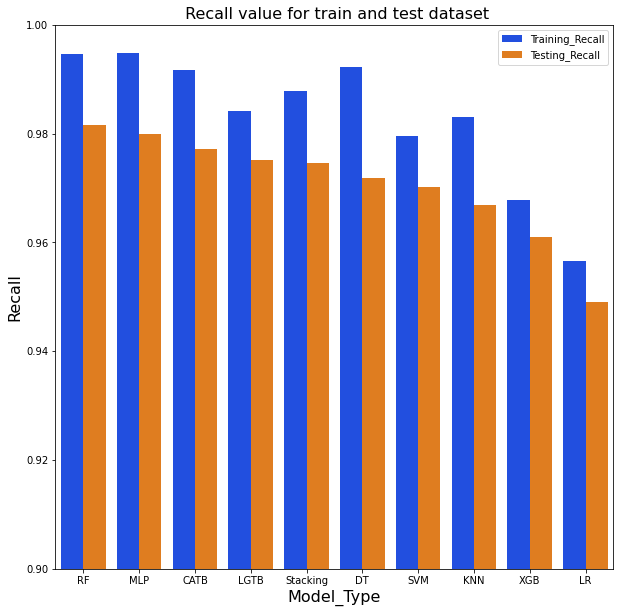

In [ ]:
# Plot for comparing Recall in training and testing data
df2 = pd.melt(Recall_sort, id_vars=['Model_Type'], value_vars=['Training_Recall','Testing_Recall'], var_name='Recall')

#fig,ax = plt.subplots()
plt.figure(figsize=(10,10))
sns.set_color_codes("bright")
sns.barplot(x="Model_Type", y="value", hue="Recall", data=df2, palette='bright')
plt.xlabel('Model_Type',fontsize=16); plt.ylabel('Recall',fontsize=16)
plt.title(' Recall value for train and test dataset',fontsize=16)
plt.ylim([0.9, 1])
plt.legend(loc='upper right',fontsize=10)

Based on the above comparision, it is clear that the **Random Forest Classifier** gives the best Recall metrics in the test data.

So, our best model is Random Forest, and it takes very less time compare to other top five models.

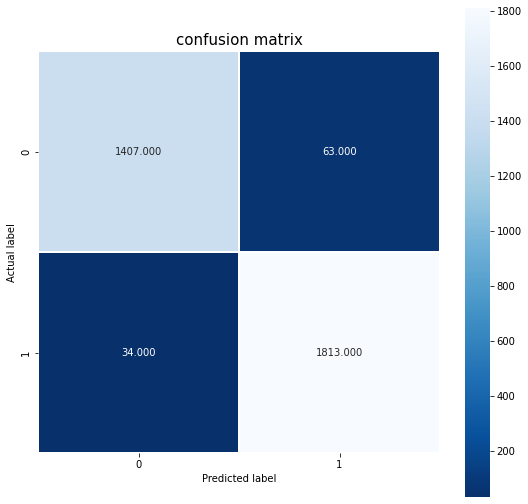

In [ ]:
# Confusion matrix on test dat from best model.
y_pred = final_model['RF'].predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Recall Score: 0.9832, '
plt.title('confusion matrix', size = 15);

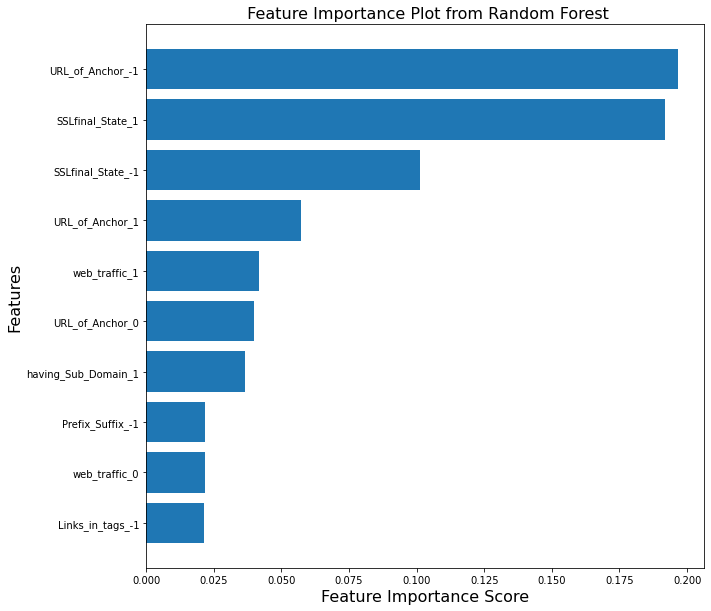

In [ ]:
# Important features from best model.
rrf = RandomForestClassifier().fit(X_train, y_train)
rrr = pd.DataFrame(np.array([X_train.columns,rrf.feature_importances_ ]).T)
rrr = rrr.sort_values(1,ascending=False)
rrr = rrr.head(10)
rrr =rrr.reset_index(drop=True)
rrr = rrr.sort_values(1,ascending=True)


plt.figure(figsize=(10,10))
plt.barh(rrr.iloc[:,0], rrr.iloc[:,1])
plt.xlabel('Feature Importance Score',fontsize=16) 
plt.ylabel('Features',fontsize=16)
plt.title(' Feature Importance Plot from Random Forest',fontsize=16);

## 7.References

*   https://scikit-learn.org/stable/user_guide.html
*   https://xgboost.readthedocs.io/en/latest/install.html
*   https://catboost.ai/
*   https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
*   https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/



